In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

In [23]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [24]:
MSFT = yf.Ticker("MSFT")
print(MSFT.info)


{'symbol': 'MSFT', 'twoHundredDayAverageChangePercent': 0.1479931, 'dividendDate': 1686182400, 'averageAnalystRating': '1.9 - Buy', 'fiftyTwoWeekLowChangePercent': 0.366256, 'language': 'en-US', 'earningsTimestampEnd': 1682683200, 'regularMarketDayRange': '282.03 - 292.08', 'epsForward': 10.75, 'regularMarketDayHigh': 292.08, 'twoHundredDayAverageChange': 37.591507, 'askSize': 10, 'twoHundredDayAverage': 254.0085, 'bookValue': 24.592, 'fiftyTwoWeekHighChange': -9.519989, 'marketCap': 2170612088832, 'fiftyTwoWeekRange': '213.43 - 301.12', 'fiftyDayAverageChange': 27.472809, 'exchangeDataDelayedBy': 0, 'firstTradeDateMilliseconds': 511108200000, 'averageDailyVolume3Month': 31808980, 'trailingAnnualDividendRate': 2.6, 'fiftyTwoWeekLow': 213.43, 'regularMarketVolume': 29770334, 'market': 'us_market', 'postMarketPrice': 291.6, 'quoteSourceName': 'Delayed Quote', 'messageBoardId': 'finmb_21835', 'priceHint': 2, 'regularMarketDayLow': 282.03, 'sourceInterval': 15, 'exchange': 'NMS', 'shortNam

In [25]:
MSFT = MSFT.history(period = '30y') # period = 'max' did not work gives no data, but this works
MSFT.to_csv('MSFT.csv')
MSFT = MSFT['Close']

In [26]:
MSFT.index = pd.to_datetime(MSFT.index).tz_localize(None)
MSFT.index

DatetimeIndex(['1993-04-07', '1993-04-08', '1993-04-12', '1993-04-13',
               '1993-04-14', '1993-04-15', '1993-04-16', '1993-04-19',
               '1993-04-20', '1993-04-21',
               ...
               '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29',
               '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06'],
              dtype='datetime64[ns]', name='Date', length=7555, freq=None)

<Axes: title={'center': 'MSFT closing prices'}, xlabel='Date'>

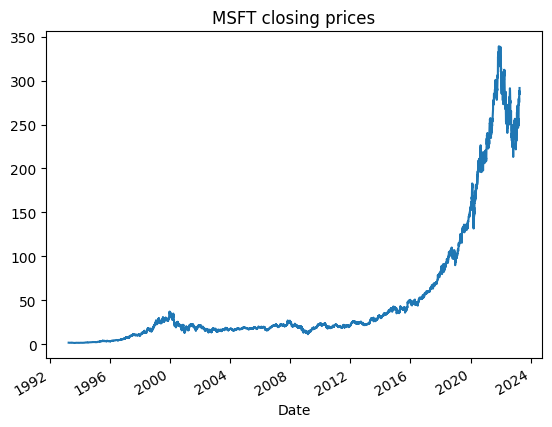

In [27]:
MSFT.plot(y='Close', title = "MSFT closing prices")

Need to convert this probelm into a supervised learning problem

In [28]:
df = MSFT.copy()
df = pd.DataFrame(df, index=df.index)
df.rename(columns={'Close':'Target'}, inplace=True)

In [29]:
def df_to_windowed_df (dataframe, first_date_str, last_date_str, n = 3):
  first_date =  pd.to_datetime(first_date_str)
  last_date  =  pd.to_datetime(last_date_str)

  for a in range(1,n+1):
    df[f'Target-{a}'] = df['Target'].shift(a)
  
  return df[(df.index>=first_date)&(df.index<=last_date)].dropna()

In [30]:
windowed_df = df_to_windowed_df(df, '1986-03-25', '2023-03-23', 3) 
windowed_df['Target Date'] = windowed_df.index

Just using the lagging closing values as input to the model. the "Target" column is the closing value on the actual date.

Changing into a numpy array. We make a function with three hourputs, X: 3D tesnsor with the input data, y is the target coloumn and Date is the date coloumn

In [31]:
windowed_df.head()

,Target,Target-1,Target-2,Target-3,Target Date
Date,,,,,
1993-04-13,1.732780,1.757151,1.735217,1.759589,1993-04-13
1993-04-14,1.735217,1.732780,1.757151,1.735217,1993-04-14
1993-04-15,1.698660,1.735217,1.732780,1.757151,1993-04-15
1993-04-16,1.696223,1.698660,1.735217,1.732780,1993-04-16
1993-04-19,1.696223,1.696223,1.698660,1.735217,1993-04-19


In [32]:
def windowed_df_to_date_X_y(windwed_df):
  df_as_np = windwed_df.to_numpy()

  dates = df_as_np[:,-1] #grabbing the target date column

  middle = df_as_np[:,1:-1]
  X = middle.reshape((len(dates), middle.shape[1],1)) # reshaping to add to Keras, using 1 variable, so 1 at the end, and first dimention is the length of the dates. second dimention is the columns
  y = df_as_np[:,0] # Get the target column

  return dates, X.astype(np.float32), y.astype(np.float32) #changing type for Keras


In [33]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((7542,), (7542, 3, 1), (7542,))

Note the shapes, This is what we wanted in terms of the dimentioning for Keras. So take home point< make sure the shapes of your X,y are correct for feeding into Keras, and the types have to be float32.

In [34]:
q_80 = int(len(dates) * 0.8) #setting up test, validation and train indexes. 
q_90 = int(len(dates) * 0.9)

# setting up train, validation and test sets

X_train = X[:q_80]
y_train = y[:q_80]
dates_train = dates[:q_80]

X_val = X[q_80:q_90]
y_val = y[q_80:q_90]
dates_val = dates[q_80:q_90]

X_test = X[q_90:]
y_test = y[q_90:]
dates_test = dates[q_90:]



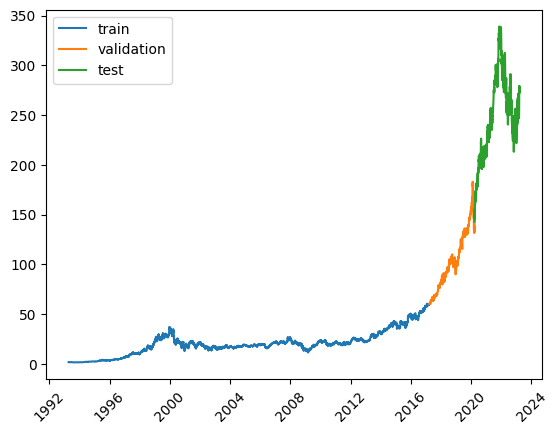

In [35]:
plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.legend(['train','validation','test'])
plt.xticks(rotation=45);

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


model = Sequential([layers.Input((3,1)), # 3 days in the past, and we only use 1 feature.
                    layers.LSTM(64), # the larger the number, its heavier, more prone to be overfitting and more connections
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)]) # 1 because we are predicting only 1 variable.

model.compile(loss = 'mse', #mean squared error
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['mean_absolute_error'])

model.fit(X_train,y_train, validation_data =(X_val, y_val), epochs = 100)

Epoch 1/100
189/189 [==============================] - 4s 7ms/step - loss: 144.8970 - mean_absolute_error: 6.7366 - val_loss: 3439.5173 - val_mean_absolute_error: 50.6376
Epoch 2/100
189/189 [==============================] - 1s 4ms/step - loss: 0.7406 - mean_absolute_error: 0.5554 - val_loss: 2812.0679 - val_mean_absolute_error: 44.1536
Epoch 3/100
189/189 [==============================] - 1s 4ms/step - loss: 0.5528 - mean_absolute_error: 0.5020 - val_loss: 2667.7827 - val_mean_absolute_error: 42.4802
Epoch 4/100
189/189 [==============================] - 1s 4ms/step - loss: 0.4658 - mean_absolute_error: 0.4497 - val_loss: 2592.4746 - val_mean_absolute_error: 41.5754
Epoch 5/100
189/189 [==============================] - 1s 4ms/step - loss: 0.4535 - mean_absolute_error: 0.4538 - val_loss: 2571.5266 - val_mean_absolute_error: 41.1624
Epoch 6/100
189/189 [==============================] - 1s 4ms/step - loss: 0.4119 - mean_absolute_error: 0.4246 - val_loss: 2577.3899 - val_mean_absolute

189/189 [==============================] - 1s 2ms/step


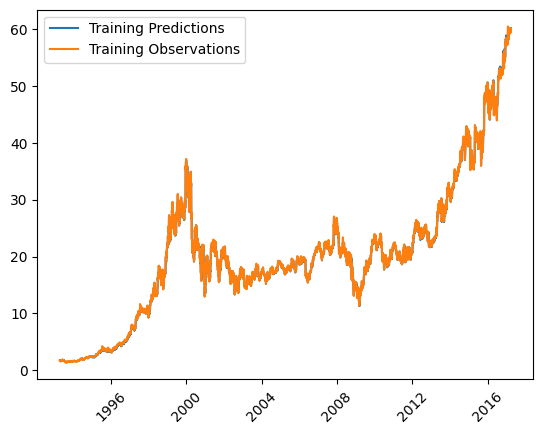

In [37]:
train_predictions = model.predict(X_train).flatten() # note the flatten

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation=45);

24/24 [==============================] - 0s 2ms/step


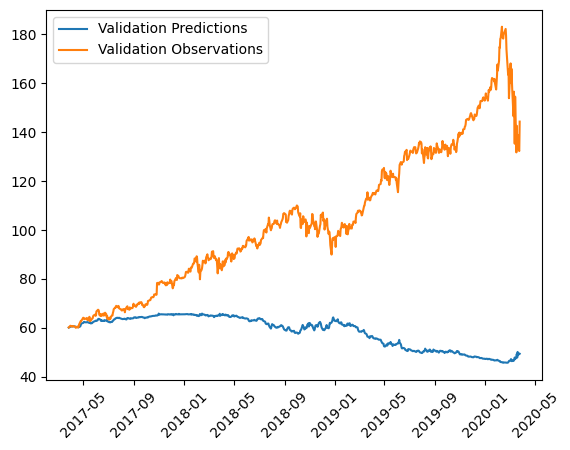

In [38]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xticks(rotation=45);

24/24 [==============================] - 0s 2ms/step


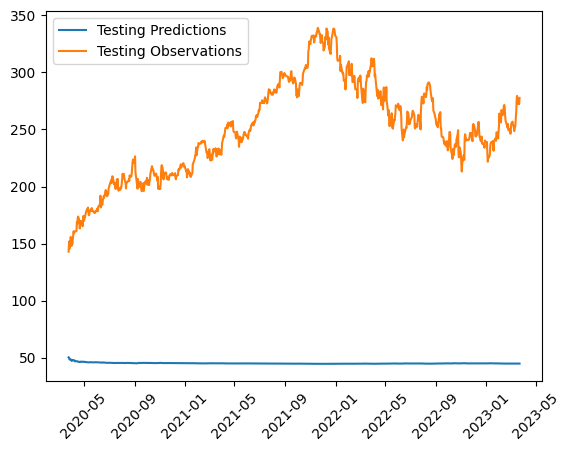

In [39]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.xticks(rotation=45);

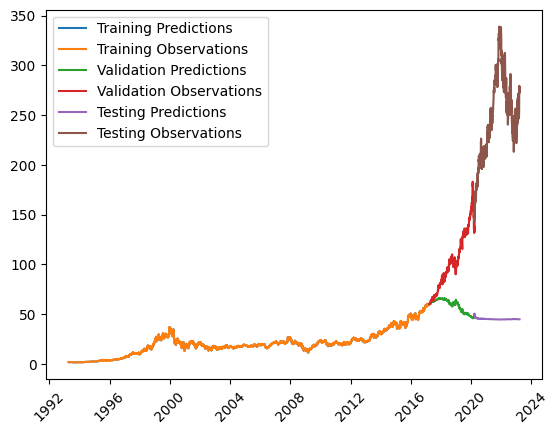

In [40]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.xticks(rotation=45);

LSTM models are very bad at extrapolating, it will not predict well if the values are outside of its range.

So you have to make sure to train on the last parts. Les see if you give it ALL the historical data:

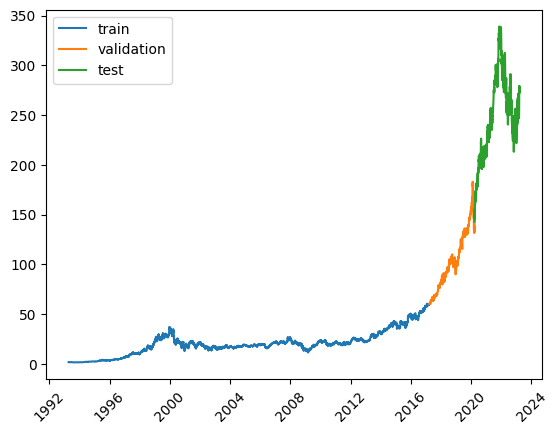

In [41]:
plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.legend(['train','validation','test'])
plt.xticks(rotation=45);

In [42]:
val_predictions = model.predict(X_val).flatten()
train_predictions = model.predict(X_train).flatten() # note the flatten
test_predictions = model.predict(X_test).flatten()


24/24 [==============================] - 0s 2ms/step


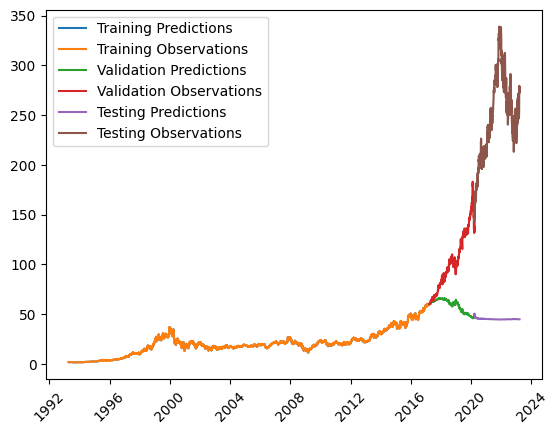

In [43]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.xticks(rotation=45);

Notice how bad it is in following the trend. 